# Tune Learning Rate for CNN on MNIST

This example walks through using botorch to tune the learning rate for a Convolution Neural Network on the MNIST dataset.

In [50]:
from typing import Dict, Tuple
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch.utils.data import DataLoader
from botorch.examples.cnn_mnist.cnn import load_mnist, CNN, train, evaluate
%matplotlib inline

In [37]:
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load MNIST data
First, we need to load the MNIST data and partition it into training, validation, and test set.

Note: this will download the dataset if necessary.

In [38]:
train_loader, valid_loader, test_loader = load_mnist()

## Define function to optimize
We need to define the function we want to optimize. In this case, we want to optimize learning rates classification accuracy on the validation set as a function of the learning rate. In addition to a tensor `X` with the parameter values (learning rates), we include additional arguments for DataLoaders for the training and evaluation sets so that this function can be reused to for a final evaluation on the test set.

Note: we define `train_evaluate` to take a tensor of `(q) x 1` points so that we can support q-batch evaluation. 

In [39]:
def train_evaluate(X: Tensor, train_loader: DataLoader, eval_loader: DataLoader) -> Tensor:
    if X.dim() == 1:
        X = X.unsqueeze(0)
    q = X.shape[0]
    accuracies = torch.empty(q, dtype=X.dtype, device=X.device)
    for i in range(q):
        params = {"lr": X[i].item()}
        net = train(
            train_loader=train_loader, 
            params=params,
            dtype=dtype,
            device=device,
        )
        accuracies[i] = evaluate(
            net=net,
            data_loader=eval_loader,
            dtype=dtype,
            device=device,
        )
    return accuracies

## Setup optimization

In [40]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition import qExpectedImprovement
from botorch.benchmarks.optimize import sequential_optimize
from botorch.fit import fit_model
from botorch.utils import draw_sobol_samples
from gpytorch.mlls import ExactMarginalLogLikelihood

In [41]:
INITIAL_POINTS = 5  # number of initial quasi-random points
SEED = 812151  # random seed
NUM_RANDOM_RESTARTS = 20  # number of starting points for multi-start optimization
NUM_RAW_SAMPLES = 10000  # Number of points to evaluate for selecting initial conditions
NUM_ROUNDS = 15  # number of iterations of bayesian optimization
Q = 1  # q-batch size

In [42]:
# set log-transformed bounds on the learning rate 
log_bounds = torch.log(torch.tensor([[1e-6], [0.3]], dtype=dtype, device=device))

## Draw and evaluate initial points
We start by drawing initial points from space filling design (Sobol sequence) in a log-transformed space. We then evaluate the initial points by training a model and computing the validation accuracy.

In [43]:
# Draw points (log scale)
X = draw_sobol_samples(
    bounds=log_bounds,
    n=1,
    q=INITIAL_POINTS,
    seed=SEED,
).squeeze(0)

# Evaluate points
Y = train_evaluate(torch.exp(X), train_loader=train_loader, eval_loader=valid_loader)

## Bayesian Optimization with q-Expected Improvement


In [44]:
for i in range(NUM_ROUNDS):
    print(f"---- Starting iteration {i+1}")
    
    # Scale inputs to [0,1]
    train_X = (X - log_bounds[0])/(log_bounds[1]-log_bounds[0])
    
    # Transform targets to N(0,1)
    train_Y = (Y - Y.mean())/max(Y.std(), 1e-8)
    
    # Define model
    model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
    
    # Fit model
    print("---- Fitting model")
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(dtype=dtype, device=device)
    mll = fit_model(mll)
    
    # Define acquisition function
    acq_func = qExpectedImprovement(
        model=model,
        best_f=model.posterior(train_X).mean.max().item(),
    )
    # Optimize acquisition function
    print("---- Optimizing acquisition function")
    candidates = sequential_optimize(
        acq_func=acq_func,
        q=Q,
        num_raw_samples=NUM_RAW_SAMPLES,
        num_starting_points=NUM_RANDOM_RESTARTS,
        candidate_optim_options={},
        lower_bounds=torch.zeros(1, dtype=dtype, device=device),
        upper_bounds=torch.ones(1, dtype=dtype, device=device),
    )
    X_new = candidates * (log_bounds[1]-log_bounds[0]) + log_bounds[0]
    # Evaluate points
    print("---- Evaluating ----")
    Y_new = train_evaluate(torch.exp(X_new), train_loader=train_loader, eval_loader=valid_loader)
    
    X = torch.cat([X, X_new], dim=0)
    Y = torch.cat([Y, Y_new], dim=0)
    

---- Starting iteration 1
---- Fitting model
---- Optimizing acquisition function


/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/botorch/posteriors/gpytorch.py:100: RuntimeWarning:

The covariance matrix is degenerate. Adding 1e-06 for numerical stability.



---- Evaluating ----
---- Starting iteration 2
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 3
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 4
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 5
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 6
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 7
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 8
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 9
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 10
---- Fitting model
---- Optimizing acquisition function


/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/botorch/posteriors/gpytorch.py:100: RuntimeWarning:

The covariance matrix is degenerate. Adding 9.999999999999999e-06 for numerical stability.



---- Evaluating ----
---- Starting iteration 11
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 12
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 13
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 14
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----
---- Starting iteration 15
---- Fitting model
---- Optimizing acquisition function
---- Evaluating ----


## Identify best parameter setting
Let's select the point with the highest classification accuracy.

In [45]:
best_objective, best_idx = Y.max(dim=0)
print(f"""Best Point:
    "lr": {round(torch.exp(X[best_idx]).item(), 6)}
""")
print(f"Classification Accuracy: {round(best_objective.item()*100, 2)}%\n")

Best Point:
    "lr": 0.006068

Classification Accuracy: 98.47%



## Plot best objective as function of the iteration

Text(0,0.5,'Classification Accuracy')

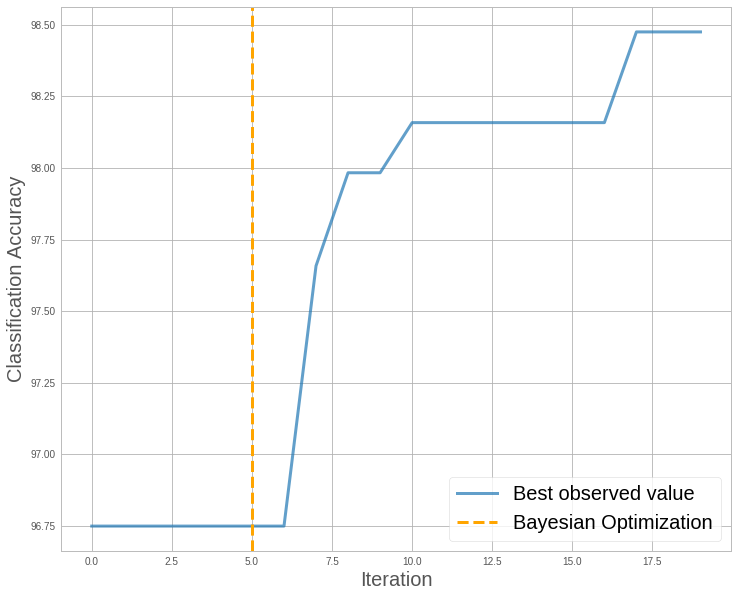

In [46]:
fig, ax = plt.subplots(1, figsize=(12,10))
fontdict = {"size": 20}
ax.plot(
    list(range(Y.shape[0])),
    np.maximum.accumulate(Y.cpu().numpy())*100,
    alpha=0.7,
    lw=3,
    label="Best observed value"
)
ax.axvline(x=INITIAL_POINTS, lw=3, ls='--', color='orange', label='Bayesian Optimization')
ax.legend(loc="lower right", prop=fontdict)
ax.set_xlabel("Iteration", fontdict=fontdict)
ax.set_ylabel("Classification Accuracy", fontdict=fontdict)



## Plot response surface
Let's inspect the response surface. Here, the response surface is our classification accuracy as a function of the learning rate.

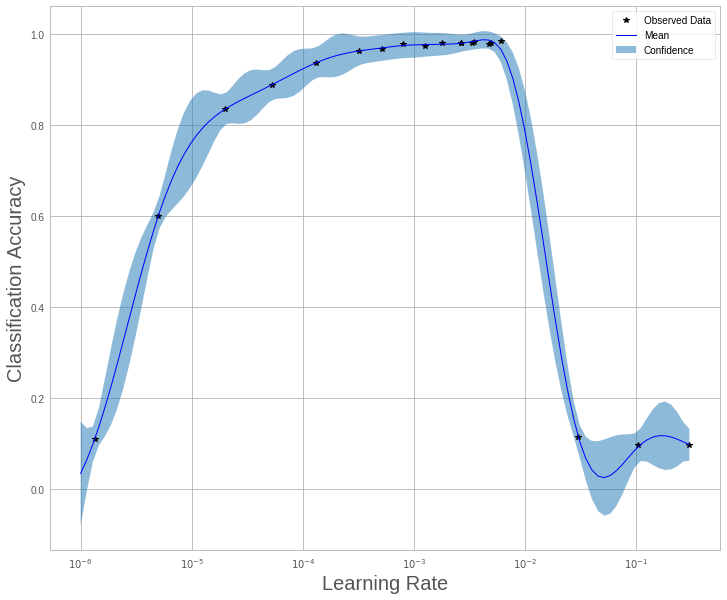

In [123]:
# Scale inputs to [0,1]
train_X = (X - log_bounds[0])/(log_bounds[1]-log_bounds[0])

# Transform targets to N(0,1)
Y_mean = Y.mean()
Y_std = max(Y.std(), 1e-8)
train_Y = (Y - Y_mean)/Y_std

# Fit model to all observations
model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
mll.to(dtype=dtype, device=device)
mll = fit_model(mll)

with torch.no_grad():
    # create points within the bounds
    test_X = torch.linspace(
        log_bounds[0].item(), 
        log_bounds[1].item(), 
        101, 
        dtype=dtype, 
        device=device
    )
    test_X_scaled = (test_X - log_bounds[0])/(log_bounds[1]-log_bounds[0])
    # evaluate posterior
    f_pred = model.posterior(test_X_scaled.view(-1,1))
    fig, ax = plt.subplots(1, figsize=(12,10))
    # Get upper and lower confidence bounds
    lower, upper = f_pred.mvn.confidence_region()
    lower = lower * Y_std + Y_mean
    upper = upper * Y_std + Y_mean
    f_mean = f_pred.mean * Y_std + Y_mean
    # Plot training data as black stars
    ax.plot(torch.exp(X).cpu().numpy(), Y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(torch.exp(test_X).cpu().numpy(), f_mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(torch.exp(test_X).cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_xscale("log")
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xlabel("Learning Rate", fontdict=fontdict)
    ax.set_ylabel("Classification Accuracy", fontdict=fontdict)

## Train CNN with best parameters and evaluate on test set

In [125]:
test_accuracy = train_evaluate(torch.exp(X[best_idx]), train_loader=train_loader, eval_loader=test_loader)

In [126]:
print(f"Classification Accuracy (test set): {round(test_accuracy.item()*100, 2)}%")

Classification Accuracy (test set): 98.55%
